# Question 2: Node Classification in a Heterogeneous Graph

In this question, you will explore node classifcation using GNNs in a heterogeneous graph with two types of nodes containing different number of features.

## Setting a Seed for Reproducibility

To ensure that our results are reproducible, we will set a fixed seed for the random number generator. This step is crucial for educational and testing purposes, as it allows the same random numbers to be generated each time the notebook is run.



In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from scipy.stats import norm
import matplotlib.pyplot as plt
import json
import torch.optim as optim
import copy
from torch.nn.functional import binary_cross_entropy
from sklearn.metrics import precision_recall_fscore_support
from torch.optim import lr_scheduler
import networkx as nx

SEED = 42
TRAIN_PATH = "data/q2_train.json"
VAL_PATH = "data/q2_val.json"

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    

set_seed(SEED)

/Users/zhayaqi/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Question 2.1 Dataset

The heterogeneous graph $G=(V,E)$ consists of a set of nodes $V$ with two types of nodes:
- **Type 1 nodes**: Feature dimension of $d_1 = 20$
- **Type 2 nodes**: Feature dimension of $d_final = 30$

Each node belongs to one of two classes:
  - **Class 0**: $y_i = 0$
  - **Class 1**: $y_i = 1$

In total, there are $N=N_1 + N_final$ nodes in the graph.

In the following cell, we load the data from the given **JSON** file.

In [2]:

def load_data_from_json(json_path):
    """
    Loads a JSON describing a heterogeneous graph

    Returns:
      A : torch.FloatTensor, shape (N, N)
          Adjacency matrix for all nodes (0...N-1).
      X1 : torch.FloatTensor, shape (N1, d1)
      X2 : torch.FloatTensor, shape (N2, d2)
      y : torch.LongTensor, shape (N,)
          Labels for each node (0 or 1 for binary).
      mapping : dict
          mapping[i] = {
             "node_type": str ("type1" or "type2"),
             "feat_index": int index into the relevant feature array
          }
        This tells us how adjacency row i corresponds to a row in either type1_features or type2_features.
    """
    with open(json_path, "r") as f:
        data = json.load(f)

    nodes_info = data["nodes"]
    # Sort so adjacency row i matches global_index = i
    nodes_info.sort(key=lambda x: x["global_index"])

    N = len(nodes_info)
    A = torch.zeros((N, N), dtype=torch.float)

    # We'll store raw lists for type1 and type2, then convert to tensors
    type1_list = []
    type2_list = []
    # We'll also store the mapping from adjacency index -> (type, index_in_that_type)
    mapping = {}
    # We'll store labels in a list
    labels_list = []

    # Step 1: first pass to build adjacency
    #         (we'll also note how many type1 vs type2)
    for i, node in enumerate(nodes_info):
        for nbr_idx in node["connected_nodes"]:
            A[i, nbr_idx] = 1.0
            A[nbr_idx, i] = 1.0  # undirected

    # Step 2: second pass, fill feature arrays, mapping
    type1_count = 0
    type2_count = 0

    for i, node in enumerate(nodes_info):
        node_type = node["node_type"]
        feats = node["features"]
        label = node["label"] if node["label"] is not None else 0
        labels_list.append(label)

        if node_type == "type1":
            type1_list.append(feats)
            mapping[i] = {"node_type": "type1", "feat_index": type1_count}
            type1_count += 1
        else:
            type2_list.append(feats)
            mapping[i] = {"node_type": "type2", "feat_index": type2_count}
            type2_count += 1

    # Convert type1 and type2 lists into float tensors
    X1 = torch.tensor(type1_list, dtype=torch.float) if len(type1_list) else torch.empty((0,0))
    X2 = torch.tensor(type2_list, dtype=torch.float) if len(type2_list) else torch.empty((0,0))

    # Convert labels
    y = torch.tensor(labels_list, dtype=torch.long)  # shape (N,)

    return A, X1, X2, y, mapping


In the following cell, we load the **train** and **validation** datasets.

In [3]:
A_train, X1_train, X2_train, y_train, mapping_train = load_data_from_json(TRAIN_PATH)
A_val,   X1_val,   X2_val,   y_val,   mapping_val   = load_data_from_json(VAL_PATH)

## Question 2.1 Interpretation of the Dataset

Before diving into the modeling phase, it's crucial to explore and understand the data. Immplement the following functions to assist in this analysis:


### Question 2.1.c `plot_graph`
- Implement the `plot_graph` function which visualizes the graph structure.
- Color nodes by class labels and display their types.



In [4]:
# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################


def plot_graph(A, y, mapping):
    """
    Visualize the graph structure with:
      - node colors based on their labels
      - node types written over the nodes
    """
    G = nx.from_numpy_array(A.numpy())

    # Color nodes by class labels
    node_colors = []
    for label in y.numpy():
        if label == 0:
            node_colors.append("blue")
        else:
            node_colors.append("red")

    # Get node type
    node_labels = {}
    for i in range(len(mapping)):
        node_labels[i] = mapping[i]["node_type"]

    # Plot
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, labels=node_labels, node_color=node_colors, 
            node_size=500, edge_color="gray", font_size=8, font_color="white")

    plt.title("Heterogeneous Graph Visualization")
    plt.show()


# ####################################################
# END OF MODIFICATION
# ####################################################


### Question 2.1.d `plot_node_feature_distributions`
Implement the `plot_node_feature_distributions` function.

- This function should plot the distribution of the node features.
- Do not consider the distribution of a specific feature $x_i$; instead, consider the mean of the feature vector $\mathbf{x}$ for each node.
- All distributions should appear on the **same figure**, so you can compare the feature distributions of $t_1$ and $t_final$ nodes as well as $c_1$ and $c_final$ nodes in Question 2.1.e
- Check Figure 1 in the Coursework Description PDF for reference on how your plot should look.


**NOTE:** The questions above are named as Question 2.1.c and Question 2.1.d by purpose to be consistent with the Coursework Description PDF, the other subquestions of Question 2 need to be answered in your report.

In [5]:
# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################
import seaborn as sns


def plot_node_feature_distributions(X1, X2, y, mapping):
    """
    Plots the distributions (as normal PDFs) of the *average* feature values
    for four groups of nodes on the *same* figure:
      * type1, class=1
      * type1, class=2
      * type2, class=1
      * type2, class=2
    """
    # Calculate mean feature
    mean_features_t1 = np.mean(X1.numpy(), axis=1)
    mean_features_t2 = np.mean(X2.numpy(), axis=1)

    # Separate nodes
    type1_class1 = [mean_features_t1[mapping[i]["feat_index"]] for i in range(len(mapping)) if mapping[i]["node_type"] == "type1" and y[i] == 0]
    type2_class1 = [mean_features_t2[mapping[i]["feat_index"]] for i in range(len(mapping)) if mapping[i]["node_type"] == "type2" and y[i] == 0]
    type1_class2 = [mean_features_t1[mapping[i]["feat_index"]] for i in range(len(mapping)) if mapping[i]["node_type"] == "type1" and y[i] == 1]
    type2_class2 = [mean_features_t2[mapping[i]["feat_index"]] for i in range(len(mapping)) if mapping[i]["node_type"] == "type2" and y[i] == 1]

    # Plot distributions
    plt.figure(figsize=(8, 6))
    sns.kdeplot(type1_class1, label="Type 1 Class 1")
    sns.kdeplot(type2_class1, label="Type 2 Class 1")
    sns.kdeplot(type1_class2, label="Type 1 Class 2")
    sns.kdeplot(type2_class2, label="Type 2 Class 2")

    plt.legend()
    plt.xlabel("Mean Feature Value")
    plt.ylabel("Density")
    plt.title("Distribution of Mean Feature Values")
    plt.grid()
    plt.show()



# ####################################################
# END OF MODIFICATION
# ####################################################

Call your functions...

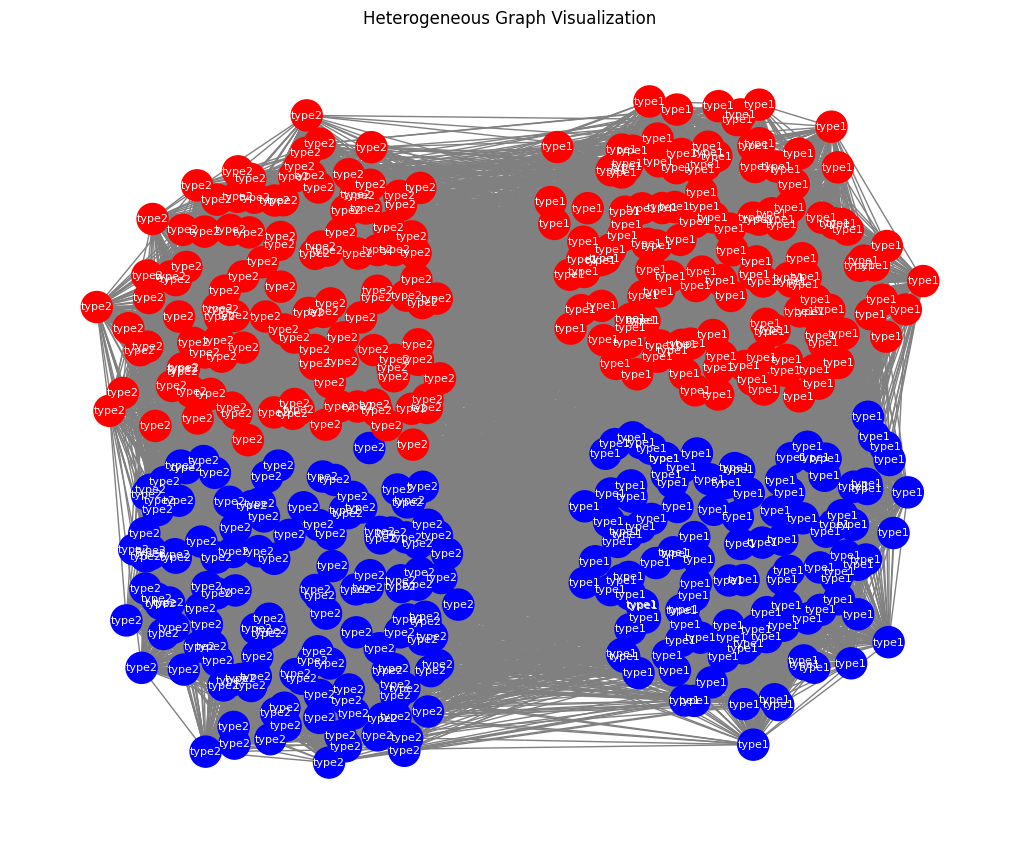

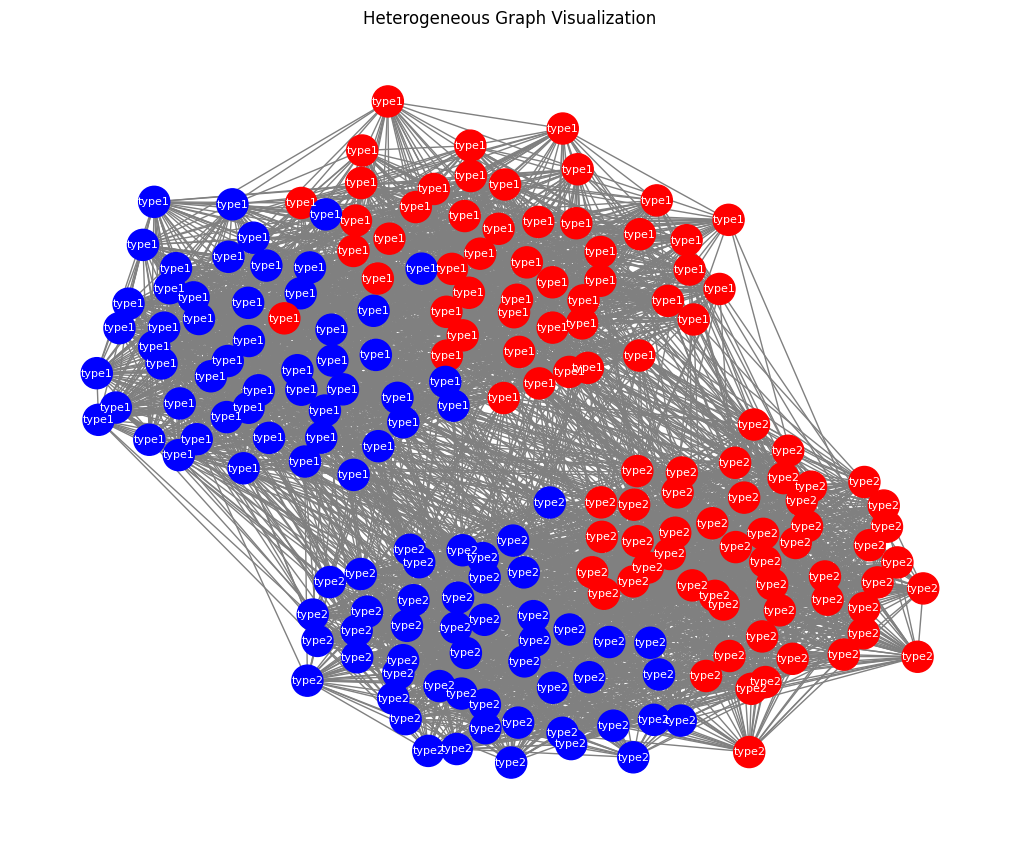

In [6]:
# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################

plot_graph(A_train, y_train, mapping_train)
plot_graph(A_val, y_val, mapping_val)

# ####################################################
# END OF MODIFICATION
# ####################################################

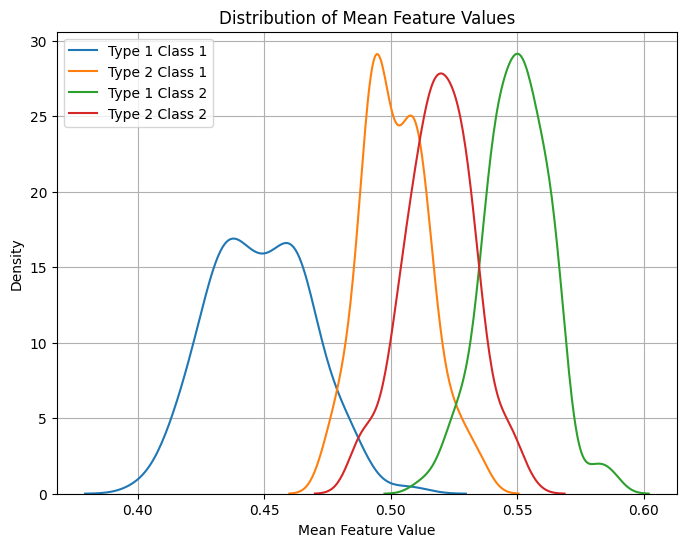

In [7]:
# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################

plot_node_feature_distributions(X1_train, X2_train, y_train, mapping_train)

# ####################################################
# END OF MODIFICATION
# ####################################################

## Question 2.2 Naive Solution

Nothing to implement in Question 2.2 :)

In the naive solution, we handle the challenge of heterogeneous node feature dimensions by zero-padding all node feature vectors to match the maximum dimension. This ensures uniformity in the input dimensions for the Graph Convolutional Network (GCN).

### Zero Padding
Let the feature dimension of a node $i$ be $d_i$. To create uniform dimensions:

$$
\mathbf{x}_i^{\text{padded}} = \begin{bmatrix}
\mathbf{x}_i \\
\mathbf{0}
\end{bmatrix},
$$

where $ \mathbf{x}_i \in \mathbb{R}^{d_i} $ is the original feature vector, and the padding $ \mathbf{0} $ is of size $ d_{\text{max}} - d_i $. Here, $ d_{\text{max}} = \max\{d_i \mid i \in \text{nodes}\} $.


In [8]:
def pad_features(A, type1_features, type2_features, mapping):
    """
    Given:
      A : (N, N) adjacency
      type1_features : (num_type1, d1)
      type2_features : (num_type2, d2)
      mapping : a dict so that mapping[i] = {"node_type": "type1" or "type2",
                                             "feat_index": index in that type's feature array}

    Produces:
      X : torch.FloatTensor, shape (N, d_max)
        Where d_max = max(d1, d2).
        For each node i, we copy either type1_features or type2_features 
        into row i, zero-padding if needed.
      d_max : the dimension used for the padding.
    """
    device = A.device
    N = A.shape[0]

    # Determine the dimensions of type1 & type2
    d1 = type1_features.shape[1] if type1_features.ndim == 2 and type1_features.shape[0] > 0 else 0
    d2 = type2_features.shape[1] if type2_features.ndim == 2 and type2_features.shape[0] > 0 else 0

    d_max = max(d1, d2)

    # Create a (N, d_max) zero tensor
    X = torch.zeros((N, d_max), dtype=torch.float, device=device)

    # Fill each row
    for i in range(N):
        node_type = mapping[i]["node_type"]
        feat_index = mapping[i]["feat_index"]
        if node_type == "type1":
            # If we have any type1 features at all
            if d1 > 0:
                X[i, :d1] = type1_features[feat_index].to(device)
        else:
            # type2
            if d2 > 0:
                X[i, :d2] = type2_features[feat_index].to(device)

    return X, d_max


### Graph Convolutional Network (GCN)

We are going to use a 2-layer GCN for the **binary node classification** task on the heterogeneous graph. Below, you can see the mathematical representation to generate predictions from GCN.

The feature update rule for the next layer $ H_{k+1} $ in a graph convolutional network is given by the equation

$$
H_{k+1} = \sigma(\tilde{D}^{-1/2} \tilde{A} \tilde{D}^{-1/2} H_k \Omega_k + \Beta_k)
$$

where  $\tilde{D}$ is the degree matrix with added self-loops, $\tilde{A}$ is the adjacency matrix with self-loops, $H_k$ are the features from the previous layer, $ \Omega_k $ is the weight matrix at layer $ k $, $\Beta_k$ is the bias vector at layer $k$, and $\sigma $ denotes the activation function.


$\tilde{D}^{-1/2} \tilde{A} \tilde{D}^{-1/2}$ is the normalized adjacency matrix with self-loops. Below, you need to implement this normalization function.

In [9]:
def symmetric_normalize(A_tilde):
    """
    Performs symmetric normalization of A_tilde (Adj. matrix with self loops):
      A_norm = D^{-1/2} * A_tilde * D^{-1/2}
    Where D_{ii} = sum of row i in A_tilde.

    A_tilde (N, N): Adj. matrix with self loops
    Returns:
      A_norm : (N, N)
    """

    eps = 1e-5
    d = A_tilde.sum(dim=1) + eps
    D_inv = torch.diag(torch.pow(d, -0.5))
    return D_inv @ A_tilde @ D_inv


In [10]:
A_train_self_loops = A_train + torch.eye(A_train.size(0))
A_val_self_loops = A_val + torch.eye(A_val.size(0))

A_train_normalized = symmetric_normalize(A_train_self_loops)
A_val_normalized = symmetric_normalize(A_val_self_loops)

In the following cell, we define a simple 2-layer GCN model to use with our padded node features.


In [11]:
class GCNLayer(nn.Module):
    """
    A single layer of a Graph Convolutional Network (GCN).
    """
    def __init__(self, input_dim, output_dim, use_nonlinearity=True):
        super(GCNLayer, self).__init__()
        self.use_nonlinearity = use_nonlinearity
        self.Omega = nn.Parameter(torch.randn(input_dim, output_dim) * torch.sqrt(torch.tensor(2.0) / (input_dim + output_dim)))
        self.beta = nn.Parameter(torch.zeros(output_dim))

    def forward(self, H_k, A_normalized):
        agg = torch.matmul(A_normalized, H_k) # local agg
        H_k_next = torch.matmul(agg, self.Omega) + self.beta
        return F.relu(H_k_next) if self.use_nonlinearity else H_k_next

class GraphNeuralNetwork(nn.Module):
    """
    A simple Graph Neural Network model using two layers of Graph Convolutional Network (GCN)
    for binary classification. The sigmoid activation is applied in the output layer only if
    use_nonlinearity is set to True.
    """
    def __init__(self, input_dim, hidden_dim):
        super(GraphNeuralNetwork, self).__init__()

        # Define GCN layers
        self.gcn1 = GCNLayer(input_dim, hidden_dim, True)
        self.gcn2 = GCNLayer(hidden_dim, 1, False)

    def forward(self, A, X, **kwargs):
        # Pass through GCN layers
        H1 = self.gcn1(X, A)
        H2 = self.gcn2(H1, A)  # Output shape: (num_nodes, 1)

        output = torch.sigmoid(H2)  # Sigmoid activation per node
        if torch.isnan(output).any():
            output = torch.where(torch.isnan(output), torch.zeros_like(output), output)

        if kwargs.get("return_embeddings", None):
            return output, H1, H2
        else:
            return output

Please do not modify the following `train_model` and `evaluate_model` functions.

In [12]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train_model(
    model,
    y_train,
    val_model_inputs,
    y_val,
    num_epochs=100,
    lr=0.01,
    validate_every=10,
    patience=10,
    **train_model_inputs
):
    """
    Train the model, validate every 'validate_every' epochs, and pick the 
    checkpoint with best validation accuracy.

    Parameters:
    -----------
    model : torch.nn.Module
        The PyTorch model to train.
    y_train : torch.Tensor
        Training labels (shape: (N,)).
    val_model_inputs : dict
        Dictionary of keyword arguments for the model's forward pass 
        for the validation set.
    y_val : torch.Tensor
        Validation labels (shape: (N_val,)).
    num_epochs : int
        Number of training epochs.
    lr : float
        Learning rate for the optimizer.
    validate_every : int
        Validate (and possibly checkpoint) every 'validate_every' epochs.
    **train_model_inputs :
        Keyword arguments for the model's forward pass for the training set.

    Returns:
    --------
    best_loss_history : list
        The training loss history across epochs.
    best_model_state_dict : dict
        The state dictionary of the model achieving the best validation accuracy.
    """

    model.train()
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=patience)
    loss_history = []

    best_val_f1 = 0.0
    best_model_state_dict = None

    for epoch in range(num_epochs):
        model.train()

        optimizer.zero_grad()


        # Forward pass on training data
        out = model(**train_model_inputs)  # shape: (N, 1)
        out = out.squeeze(-1)  # shape: (N,)
        y_float = y_train.float()  # for BCE

        # Compute training loss
        loss = binary_cross_entropy(out, y_float)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        # Record training loss
        loss_value = loss.item()
        loss_history.append(loss_value)

        # Validation step
        if (epoch + 1) % validate_every == 0 or (epoch + 1) == num_epochs:
            val_prec, val_rec, val_f1, _ = evaluate_model(model, y_val, **val_model_inputs)
            scheduler.step(val_f1)
            
            lr = get_lr(optimizer)

            print(
                f"Epoch {epoch+1}/{num_epochs} - "
                f"Train Loss: {loss_value:.4f} - "
                f"Val Precision: {val_prec:.4f} - "
                f"Val Recall: {val_rec:.4f} - "
                f"Val F1: {val_f1:.4f} - "
                f"LR: {lr}"
            )
    
            # Check if this is the best f1 score so far
            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                best_model_state_dict = copy.deepcopy(model.state_dict())


            if lr < 1e-5:
                break

    
    # If we have a best model, load it
    if best_model_state_dict is not None:
        model.load_state_dict(best_model_state_dict)

    return loss_history, best_model_state_dict


@torch.no_grad()
def evaluate_model(model, y, **kwargs):
    """
    Runs forward pass, calculates binary predictions (threshold=0.5),
    and returns the accuracy score.
    """
    model.eval()
    out = model(**kwargs)  # shape: (N, 1)
    out = out.squeeze(-1)  # shape: (N,)
    preds = (out >= 0.5).long()

    y_true = y.cpu().numpy()
    y_pred = preds.cpu().numpy()

    return precision_recall_fscore_support(y_true, y_pred, average="micro")


Helper function to plot the history of loss during the training.

In [13]:
def plot_loss(loss_history, title):
    plt.figure()
    plt.plot(loss_history, label="loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.show()

In [14]:

def plot_results(val_precs, val_recs, val_f1s, title_prefix='', figsize=(15,5)):
    """
    Plots three bar charts comparing precision, recall, and F1 scores 
    for multiple models on a single figure, each sorted by its own metric.
    The best model is always on the right for each plot.
    
    Args:
        val_precs (dict): Dictionary of model -> precision score
        val_recs (dict): Dictionary of model -> recall score
        val_f1s (dict): Dictionary of model -> F1 score
        title_prefix (str): Optional prefix for subplot titles
        figsize (tuple): Size of the overall figure
    """
    
    # Prepare the figure
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    
    # --- Sort and plot Precision ---
    # Sort by precision (ascending), so best is on the right
    sorted_precs = sorted(val_precs.items(), key=lambda x: x[1])
    prec_models = [x[0] for x in sorted_precs]  # model names
    prec_scores = [x[1] for x in sorted_precs]  # scores
    min_prec = min(prec_scores)
    
    axes[0].bar(prec_models, prec_scores, color='skyblue')
    # Start the y-axis a bit lower than the min value
    axes[0].set_ylim([
        min_prec - 0.05*(1 if min_prec == 0 else min_prec), 
        max(1.0, max(prec_scores))  # in case some scores > 1.0
    ])
    axes[0].set_title(f'{title_prefix}Precision', fontsize=12)
    axes[0].set_ylabel('Score')
    axes[0].set_xticks(range(len(prec_models)))
    axes[0].set_xticklabels(prec_models, rotation=45, ha='right')
    
    # --- Sort and plot Recall ---
    sorted_recs = sorted(val_recs.items(), key=lambda x: x[1])
    rec_models = [x[0] for x in sorted_recs]
    rec_scores = [x[1] for x in sorted_recs]
    min_recs = min(rec_scores)
    
    axes[1].bar(rec_models, rec_scores, color='salmon')
    axes[1].set_ylim([
        min_recs - 0.05*(1 if min_recs == 0 else min_recs),
        max(1.0, max(rec_scores))
    ])
    axes[1].set_title(f'{title_prefix}Recall', fontsize=12)
    axes[1].set_xticks(range(len(rec_models)))
    axes[1].set_xticklabels(rec_models, rotation=45, ha='right')
    
    # --- Sort and plot F1 ---
    sorted_f1s = sorted(val_f1s.items(), key=lambda x: x[1])
    f1_models = [x[0] for x in sorted_f1s]
    f1_scores = [x[1] for x in sorted_f1s]
    min_f1 = min(f1_scores)
    
    axes[2].bar(f1_models, f1_scores, color='limegreen')
    axes[2].set_ylim([
        min_f1 - 0.05*(1 if min_f1 == 0 else min_f1),
        max(1.0, max(f1_scores))
    ])
    axes[2].set_title(f'{title_prefix}F1', fontsize=12)
    axes[2].set_xticks(range(len(f1_models)))
    axes[2].set_xticklabels(f1_models, rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()


In [15]:
val_precs, val_recs, val_f1s = {}, {}, {}

Running the naive approach

Train adjacency: torch.Size([500, 500])
Train features after padding: torch.Size([500, 30]) with d_max = 30
Val adjacency: torch.Size([200, 200])
Val features after padding: torch.Size([200, 30]) with d_max = 30
Epoch 10/10000 - Train Loss: 0.6906 - Val Precision: 0.5000 - Val Recall: 0.5000 - Val F1: 0.5000 - LR: 0.01
Epoch 20/10000 - Train Loss: 0.6883 - Val Precision: 0.4900 - Val Recall: 0.4900 - Val F1: 0.4900 - LR: 0.01
Epoch 30/10000 - Train Loss: 0.6868 - Val Precision: 0.4900 - Val Recall: 0.4900 - Val F1: 0.4900 - LR: 0.01
Epoch 40/10000 - Train Loss: 0.6866 - Val Precision: 0.4900 - Val Recall: 0.4900 - Val F1: 0.4900 - LR: 0.01
Epoch 50/10000 - Train Loss: 0.6863 - Val Precision: 0.4900 - Val Recall: 0.4900 - Val F1: 0.4900 - LR: 0.01
Epoch 60/10000 - Train Loss: 0.6860 - Val Precision: 0.4900 - Val Recall: 0.4900 - Val F1: 0.4900 - LR: 0.01
Epoch 70/10000 - Train Loss: 0.6856 - Val Precision: 0.4900 - Val Recall: 0.4900 - Val F1: 0.4900 - LR: 0.01
Epoch 80/10000 - Train Lo

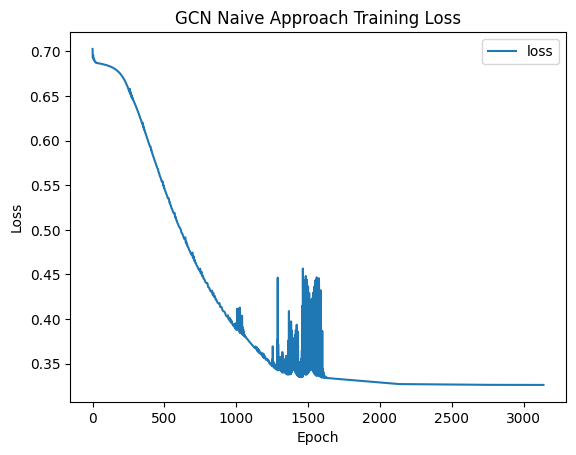

In [16]:
set_seed(SEED)

# Naively pad
X_train, d_max_train = pad_features(A_train, X1_train, X2_train, mapping_train)
X_val,   d_max_val   = pad_features(A_val,   X1_val,   X2_val,   mapping_val)

print("Train adjacency:", A_train.shape)
print("Train features after padding:", X_train.shape, "with d_max =", d_max_train)
print("Val adjacency:", A_val.shape)
print("Val features after padding:", X_val.shape, "with d_max =", d_max_val)

# Convert labels to float if using BCE with sigmoid
y_train = y_train.float()  # shape (N,)
y_val   = y_val.float()

# Build the GCN model
input_dim = X_train.shape[1]  # the padded dimension
hidden_dim = 2
naive_gnn_model = GraphNeuralNetwork(input_dim, hidden_dim)

# Train
loss_history, _ = train_model(naive_gnn_model, y_train, val_model_inputs={"A":A_val_normalized.clone(), "X":X_val.clone()}, y_val=y_val.clone(), A=A_train_normalized, X=X_train, num_epochs=10000, lr=0.01, patience=50)

# Test on validation data
val_prec, val_rec, val_f1, _ = evaluate_model(naive_gnn_model, y_val, A=A_val_normalized, X=X_val)
print(f"[VAL] Prec={val_prec:.4f}, Rec={val_rec:.4f}, F1={val_f1:.4f}")

val_precs["Naive GCN"] = val_prec
val_recs["Naive GCN"] = val_rec
val_f1s["Naive GCN"] = val_f1

# Plot loss
plot_loss(loss_history, title="GCN Naive Approach Training Loss")


## Question 2.3 Node-Type Aware GCN

In this task, **design and implement** a node-type aware 2-layer GCN model that explicitly accounts for two distinct node types and performs binary node classification. Your design should adhere to the following requirements:

- Consider two types of nodes without using padding.
- Limit your model to **two layers**, as in the naive solution.
- You may either use the provided `GCNLayer` and `GraphNeuralNetwork` classes or implement your own classes. However, the final model architecture must be implemented within the `HeteroGCN` class.
- While you are allowed to introduce additional learnable parameters, your approach must **explicitly** account for different node types rather than merely increasing the number of learnable parameters.
- Determine the optimal hyperparameters for your model, such as hidden dimensions, learning rate, scheduler patience, etc. These hyperparameters do not need to match those of the naive model, as each design has its own optimal configuration.
- Your model must achieve superior **validation F1 score** compared to the naive approach.
- You may use different versions of adjacency matrices in your implementation:
  - Unmodified adjacency matrices, i.e., `A_train`.
  - Self-looped adjacency matrices, i.e., `A_train_self_loops`.
  - Normalized adjacency matrices, i.e., `A_train_normalized`.

Please see the Coursework Description PDF Question 2.3 for more details

In [17]:
# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################

import torch
import torch.nn as nn
import torch.nn.functional as F

class HeteroGCN(nn.Module):
    """
    A 2-layer heterogeneous GCN for binary classification on two node types
    """
    def __init__(self, in_dim_t1, in_dim_t2, hidden_dim=8, dropout_t1=0.3, dropout_t2=0.1):
        super().__init__()

        # Different Normalization
        self.norm_t1 = nn.BatchNorm1d(in_dim_t1)
        self.norm_t2 = nn.BatchNorm1d(in_dim_t2)

        # Different Dropout
        self.dropout_t1 = nn.Dropout(dropout_t1)
        self.dropout_t2 = nn.Dropout(dropout_t2)

        # First Layer
        # type1: (in_dim_t1) -> hidden_dim
        # type2: (in_dim_t2) -> hidden_dim
        self.t1_to_t1_hidden = nn.Linear(in_dim_t1, hidden_dim, bias=False)
        self.t2_to_t1_hidden = nn.Linear(in_dim_t2, hidden_dim, bias=False)
        self.bias_t1_hidden = nn.Parameter(torch.zeros(hidden_dim))

        self.t1_to_t2_hidden = nn.Linear(in_dim_t1, hidden_dim, bias=False)
        self.t2_to_t2_hidden = nn.Linear(in_dim_t2, hidden_dim, bias=False)
        self.bias_t2_hidden = nn.Parameter(torch.zeros(hidden_dim))

        # Second Layer
        # type1/type2: hidden_dim -> 1
        self.t1_to_t1_final = nn.Linear(hidden_dim, 1, bias=False)
        self.t2_to_t1_final = nn.Linear(hidden_dim, 1, bias=False)
        self.bias_t1_final = nn.Parameter(torch.zeros(1))

        self.t1_to_t2_final = nn.Linear(hidden_dim, 1, bias=False)
        self.t2_to_t2_final = nn.Linear(hidden_dim, 1, bias=False)
        self.bias_t2_final = nn.Parameter(torch.zeros(1))

    def forward(self, A, X1, X2, t1_idx, t2_idx):
        # Normalization and Dropout
        X1 = self.norm_t1(X1)
        X1 = self.dropout_t1(X1)
        X2 = self.norm_t2(X2)
        X2 = self.dropout_t2(X2)

        # Get Sub-adjacency
        A_t1_t1 = A[t1_idx][:, t1_idx]  
        A_t1_t2 = A[t1_idx][:, t2_idx]
        A_t2_t1 = A[t2_idx][:, t1_idx]
        A_t2_t2 = A[t2_idx][:, t2_idx]

        # First Layer
        H1_t1 = (A_t1_t1 @ self.t1_to_t1_hidden(X1)
                 + A_t1_t2 @ self.t2_to_t1_hidden(X2)
                 + self.bias_t1_hidden)
        H1_t1 = F.relu(H1_t1)

        H1_t2 = (A_t2_t1 @ self.t1_to_t2_hidden(X1)
                 + A_t2_t2 @ self.t2_to_t2_hidden(X2)
                 + self.bias_t2_hidden)
        H1_t2 = F.relu(H1_t2)

        # Second Layer
        output_t1 = (A_t1_t1 @ self.t1_to_t1_final(H1_t1)
                     + A_t1_t2 @ self.t2_to_t1_final(H1_t2)
                     + self.bias_t1_final)
        output_t2 = (A_t2_t1 @ self.t1_to_t2_final(H1_t1)
                     + A_t2_t2 @ self.t2_to_t2_final(H1_t2)
                     + self.bias_t2_final)

        # Merges t1 and t2 outputs
        output = torch.zeros((A.shape[0], 1))
        output[t1_idx] = output_t1
        output[t2_idx] = output_t2

        # Apply sigmoid
        output = torch.sigmoid(output)

        return output

# ####################################################
# END OF MODIFICATION
# ####################################################

Epoch 10/150 - Train Loss: 53.2000 - Val Precision: 0.5100 - Val Recall: 0.5100 - Val F1: 0.5100 - LR: 0.005
Epoch 20/150 - Train Loss: 26.6194 - Val Precision: 0.5000 - Val Recall: 0.5000 - Val F1: 0.5000 - LR: 0.005
Epoch 30/150 - Train Loss: 0.0005 - Val Precision: 0.5000 - Val Recall: 0.5000 - Val F1: 0.5000 - LR: 0.005
Epoch 40/150 - Train Loss: 0.0910 - Val Precision: 0.6850 - Val Recall: 0.6850 - Val F1: 0.6850 - LR: 0.005
Epoch 50/150 - Train Loss: 0.0085 - Val Precision: 0.9100 - Val Recall: 0.9100 - Val F1: 0.9100 - LR: 0.005
Epoch 60/150 - Train Loss: 0.0543 - Val Precision: 0.9450 - Val Recall: 0.9450 - Val F1: 0.9450 - LR: 0.005
Epoch 70/150 - Train Loss: 0.0000 - Val Precision: 0.9600 - Val Recall: 0.9600 - Val F1: 0.9600 - LR: 0.005
Epoch 80/150 - Train Loss: 0.0000 - Val Precision: 0.9300 - Val Recall: 0.9300 - Val F1: 0.9300 - LR: 0.005
Epoch 90/150 - Train Loss: 0.0000 - Val Precision: 0.8950 - Val Recall: 0.8950 - Val F1: 0.8950 - LR: 0.005
Epoch 100/150 - Train Loss

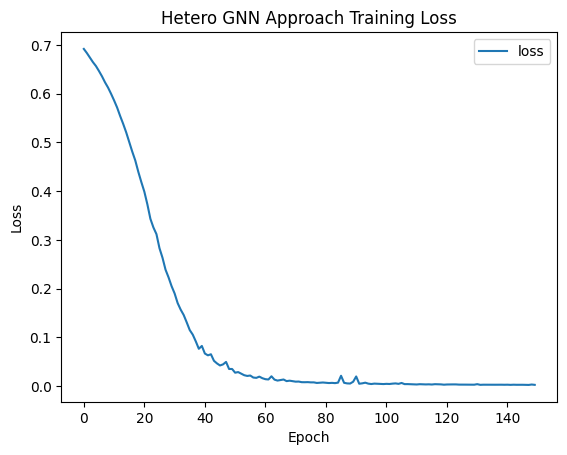

In [18]:
set_seed(SEED)

# Convert labels to float if using BCE with sigmoid
y_train = y_train.float()  # shape (N,)
y_val   = y_val.float()

# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################
# Get idx from training and validation sets for different classes
t1_idx_train = [i for i in range(len(mapping_train)) if mapping_train[i]["node_type"] == "type1"]
t2_idx_train = [i for i in range(len(mapping_train)) if mapping_train[i]["node_type"] == "type2"]

t1_idx_val = [i for i in range(len(mapping_val)) if mapping_val[i]["node_type"] == "type1"]
t2_idx_val = [i for i in range(len(mapping_val)) if mapping_val[i]["node_type"] == "type2"]

# Hyperparameter Tuning
hidden_dims = [8, 16, 32, 64]
adjacency_matrices = {
    "Unmodified": A_train,
    "Self-Looped": A_train_self_loops,
    "Normalized": A_train_normalized
}
best_f1 = 0.0
best_hyperparams = None
results = []

for hidden_dim in hidden_dims:
    for adj_name, adj_matrix in adjacency_matrices.items():
        # Build the HeteroGCN model
        hetero_gcn = HeteroGCN(
            in_dim_t1=X1_train.shape[1],
            in_dim_t2=X2_train.shape[1],
            hidden_dim=hidden_dim
        )
        
        # Training arguments
        train_inputs = {
            "A": adj_matrix,
            "X1": X1_train,
            "X2": X2_train,
            "t1_idx": t1_idx_train,
            "t2_idx": t2_idx_train
        }

        if adj_name == "Unmodified":
            A_val_method = A_val
        elif adj_name == "Self-Looped":
            A_val_method = A_val_self_loops
        else:
            A_val_method = A_val_normalized

        val_inputs = {
            "A": A_val_method,
            "X1": X1_val,
            "X2": X2_val,
            "t1_idx": t1_idx_val,
            "t2_idx": t2_idx_val
        }

        # Train the model
        loss_history, _ = train_model(
            model=hetero_gcn,
            y_train=y_train,
            val_model_inputs=val_inputs, 
            y_val=y_val,
            num_epochs=150,
            lr=0.005,
            patience=10,
            validate_every=10,
            **train_inputs
        )

        # Evaluate model
        val_prec, val_rec, val_f1, _ = evaluate_model(hetero_gcn, y_val, **val_inputs)
        print(f"Hidden={hidden_dim}, Adj={adj_name} : Prec={val_prec:.4f}, Rec={val_rec:.4f}, F1={val_f1:.4f}")

        # Store results
        results.append((hidden_dim, adj_name, val_f1))
        
        # Update best model
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_hyperparams = (hidden_dim, adj_name)
            best_model = copy.deepcopy(hetero_gcn)

# Print best hyperparameters
print(f"\nBest Hyperparameters: Hidden Dim = {best_hyperparams[0]}, Adjacency = {best_hyperparams[1]}:  F1 Score = {best_f1:.4f}")

# ####################################################
# END OF MODIFICATION
# ####################################################

# Test on validation data
print("Final Test on best model")
val_prec, val_rec, val_f1, _ = evaluate_model(best_model, y_val, **val_inputs)
print(f"[VAL] Prec={val_prec:.4f}, Rec={val_rec:.4f}, F1={val_f1:.4f}")

val_precs["Hetero GCN"] = val_prec
val_recs["Hetero GCN"] = val_rec
val_f1s["Hetero GCN"] = val_f1

# Plot loss
plot_loss(loss_history, title="Hetero GNN Approach Training Loss")


## Question 2.4 Exploring Attention
In this question, you will explore the attention-based aggregation mechanism in GNNs. Attention-based aggregation is explained in [Lecture 3.5](https://www.youtube.com/watch?v=zRmzVkidkqA&list=PLug43ldmRSo14Y_vt7S6vanPGh-JpHR7T&index=14).

- Implement an attention-based aggregation mechanism for binary node classification using GCNs.
- Limit your model to **two layers**, as in Question 2.2 and Question 2.3
- Base your implementation on the naive padding approach introduced in Question 2.2
- **Do not** implement a node-type aware special design as in Question 2.3
- Your implementation must achieve a better **validation F1 score** compared to the naive GCN in Question 2.2
- Determine the optimal hyperparameters for your model, such as hidden dimensions, learning rate, scheduler patience, etc. These hyperparameters do not need to match those of the previous models, as each design has its own optimal configuration. Explain your hyperparameter tuning process **in detail** in your report.



In [19]:
# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################


class GANLayer(nn.Module):
    def __init__(self, input_dim, output_dim, use_nonlinearity=True):
        super(GANLayer, self).__init__()
        self.use_nonlinearity = use_nonlinearity
        self.Omega = nn.Parameter(torch.randn(input_dim, output_dim) * torch.sqrt(torch.tensor(2.0) / (input_dim + output_dim)))
        self.beta = nn.Parameter(torch.zeros(output_dim))
        
        self.attn = nn.Parameter(torch.randn(2 * output_dim) * 0.01)
        self.leakyrelu = nn.LeakyReLU(0.2)
        self.bn = nn.BatchNorm1d(output_dim)

    def forward(self, H_k, A):
        # 1) Linear Transformation
        H_trans = H_k @ self.Omega + self.beta
        N = H_trans.size(0)

        H_trans = self.bn(H_trans)
        
        # 2) Calculate the similarity matix
        H_m = H_trans.unsqueeze(1).repeat(1, N, 1)
        H_n = H_trans.unsqueeze(0).repeat(N, 1, 1)
        H_cat = torch.cat([H_m, H_n], dim=-1)
        S = torch.einsum('ijk,k->ij', H_cat, self.attn)
        S = self.leakyrelu(S)  
        
        # Apply softmax
        S = torch.where(A > 0, S, torch.finfo(torch.float32).min)
        softmask = F.softmax(S, dim=1)
        
        # Aggregate neighbor embeddings
        H_k_plus_1 = softmask @ H_trans

        if self.use_nonlinearity:
            H_k_plus_1 = F.relu(H_k_plus_1)
        
        return H_k_plus_1

class GraphAttentionNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GraphAttentionNetwork, self).__init__()
        self.gcn1 = GANLayer(input_dim, hidden_dim, use_nonlinearity=True)
        self.gcn2 = GANLayer(hidden_dim, 1, use_nonlinearity=False)

    def forward(self, A, X, **kwargs):
        H1 = self.gcn1(X, A)
        H2 = self.gcn2(H1, A)

        # Apply sigmoid
        output = torch.sigmoid(H2)
        
        if torch.isnan(output).any():
            output = torch.where(torch.isnan(output), torch.zeros_like(output), output)

        if kwargs.get("return_embeddings", None):
            return output, H1, H2
        else:
            return output

# ####################################################
# END OF MODIFICATION
# ####################################################

Train adjacency: torch.Size([500, 500])
Train features after padding: torch.Size([500, 30]) with d_max = 30
Val adjacency: torch.Size([200, 200])
Val features after padding: torch.Size([200, 30]) with d_max = 30
Epoch 10/300 - Train Loss: 0.7946 - Val Precision: 0.5150 - Val Recall: 0.5150 - Val F1: 0.5150 - LR: 0.001
Epoch 20/300 - Train Loss: 0.7821 - Val Precision: 0.4900 - Val Recall: 0.4900 - Val F1: 0.4900 - LR: 0.001
Epoch 30/300 - Train Loss: 0.7662 - Val Precision: 0.4950 - Val Recall: 0.4950 - Val F1: 0.4950 - LR: 0.001
Epoch 40/300 - Train Loss: 0.7463 - Val Precision: 0.5000 - Val Recall: 0.5000 - Val F1: 0.5000 - LR: 0.001
Epoch 50/300 - Train Loss: 0.7191 - Val Precision: 0.5000 - Val Recall: 0.5000 - Val F1: 0.5000 - LR: 0.001
Epoch 60/300 - Train Loss: 0.6704 - Val Precision: 0.5000 - Val Recall: 0.5000 - Val F1: 0.5000 - LR: 0.001
Epoch 70/300 - Train Loss: 0.5649 - Val Precision: 0.5000 - Val Recall: 0.5000 - Val F1: 0.5000 - LR: 0.001
Epoch 80/300 - Train Loss: 0.550

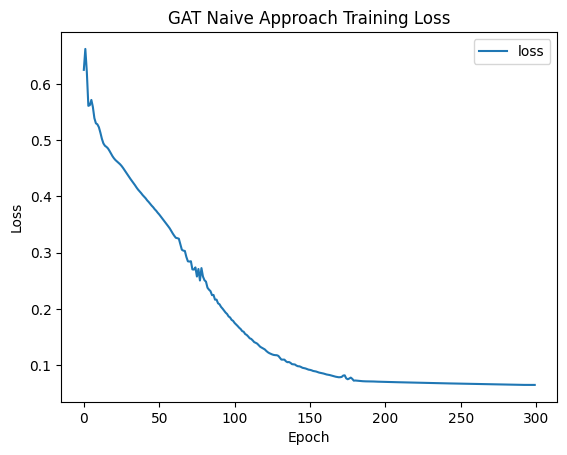

In [20]:
set_seed(SEED)

# Naively pad
X_train, d_max_train = pad_features(A_train, X1_train, X2_train, mapping_train)
X_val,   d_max_val   = pad_features(A_val,   X1_val,   X2_val,   mapping_val)

print("Train adjacency:", A_train.shape)
print("Train features after padding:", X_train.shape, "with d_max =", d_max_train)
print("Val adjacency:", A_val.shape)
print("Val features after padding:", X_val.shape, "with d_max =", d_max_val)

# Convert labels to float if using BCE with sigmoid
y_train = y_train.float()  # shape (N,)
y_val   = y_val.float()


# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################

# Hyperparameter Tuning
hidden_dims = [8, 16, 32]
learning_rates = [0.001, 0.005, 0.01]

best_f1 = 0.0
best_model = None
best_hyperparams = None
results = []

for hidden_dim in hidden_dims:
    for lr in learning_rates:
         # Build the GAN model
        attn_gnn = GraphAttentionNetwork(input_dim=X_train.shape[1], hidden_dim=hidden_dim)

        # Training arguments
        train_inputs = {
            "A": A_train_normalized,
            "X": X_train
        }
        val_inputs = {
            "A": A_val_normalized,
            "X": X_val
        }

        # Train the model
        loss_history, _ = train_model(
            model=attn_gnn,
            y_train=y_train,
            val_model_inputs=val_inputs,
            y_val=y_val,
            num_epochs=300,
            lr=lr,        
            patience=10,
            validate_every=10,
            **train_inputs
        )

        # Evaluate model
        val_prec, val_rec, val_f1, _ = evaluate_model(attn_gnn, y_val, **val_inputs)
        print(f"Hidden={hidden_dim}, Lr={lr} : Prec={val_prec:.4f}, Rec={val_rec:.4f}, F1={val_f1:.4f}")

        # Store results
        results.append((hidden_dim, lr, val_f1))

        # Update best model
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_hyperparams = (hidden_dim, lr)
            best_model = copy.deepcopy(attn_gnn)

# Print best hyperparameters
print(f"\nBest Hyperparameters: Hidden Dim = {best_hyperparams[0]}, LR={best_hyperparams[1]}:  F1 Score = {best_f1:.4f}")


# ####################################################
# END OF MODIFICATION
# ####################################################

# Test on validation data
print("Final Test on best model")
val_prec, val_rec, val_f1, _ = evaluate_model(best_model, y_val, **val_inputs)
print(f"[VAL] Prec={val_prec:.4f}, Rec={val_rec:.4f}, F1={val_f1:.4f}")

val_precs["Naive GAT"] = val_prec
val_recs["Naive GAT"] = val_rec
val_f1s["Naive GAT"] = val_f1

# Plot loss
plot_loss(loss_history, title="GAT Naive Approach Training Loss")


## Question 2.5 Discussion

In your report, include the bar plot comparing the **precision, recall, and F1 scores** of the three models, generated using the following function call. Explain your results in your report.

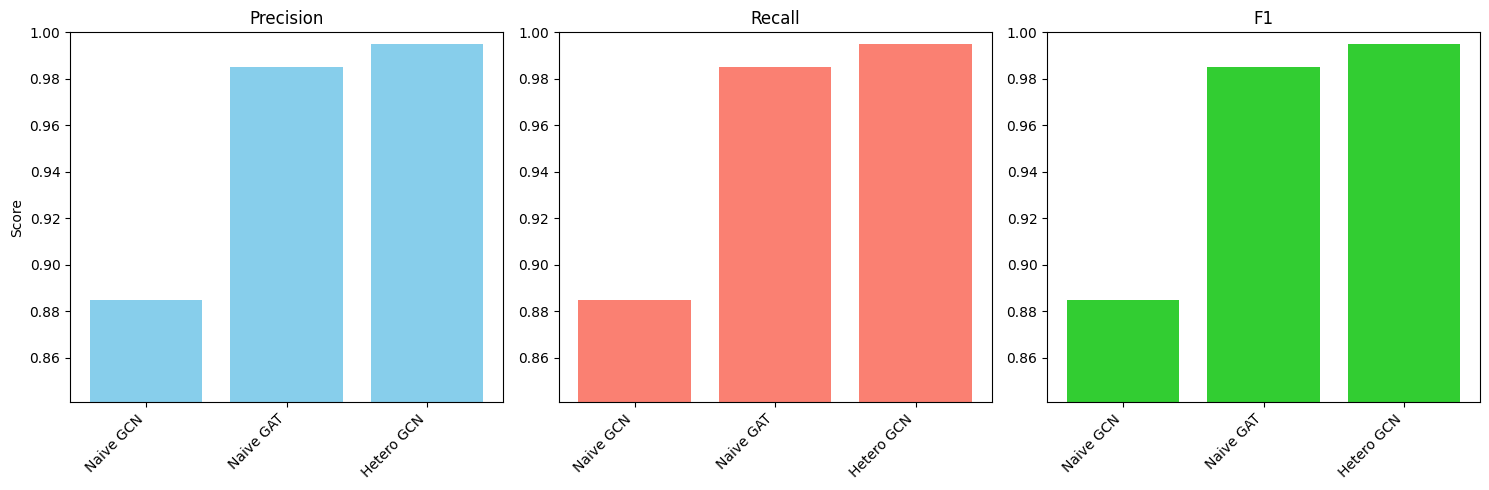

In [21]:
plot_results(val_precs, val_recs, val_f1s)